### vgg16기반 전이학습(개, 고양이 분류) 
- By [haven-jeon](https://github.com/haven-jeon)

####  전이학습(transfer learning)으로 모형 재사용하기

전이학습은 꽤 오래된 주제지만 실무에서 활용한만한 가치가 높은 기법중에 하나이다. 특히나 이미지 관련 분류 모형에서는 이 기법은 거의 필수라고 생각하고 일반적인 기술일 것이다. 이 기법은 기존 분류에 대한 성능이 좋은 네트워크와 가중치를 일부 혹은 전부 가져와 상위 레이어를 튜닝하는 방식으로 자신이 원하는 문제를 풀게 모형을 재활용 혹은 전용하는 방법이다. 
특히나 학습셋이 부족한 경우 그리고 문제영역 자체가 세부 영역으로 좁혀진 경우 매우 활용 가치가 높다. 


데이터는 [kaggle](https://www.kaggle.com/c/dogs-vs-cats)에서 획득한 `train.zip`을 활용했다. 이 노트북이 존재하는 경로에 그대로 압축을 풀어서 작업을 수행했다. 

아래와 같은 과정으로 진행된다. 

1. jpg를 Image RecordIO dataset 파일로 전환 [이 문서](https://mxnet.incubator.apache.org/how_to/recordio.html?highlight=im2rec)를 주로 참고했다. 
1. 모형 아키텍처 정의 (vgg16 기반)
1. 학습/평가
1. 예제 적용 

해당 모형을 전이학습이 아닌 모형으로 전이학습이 된 모형정도의 성능을 나오게 하는건 매우 어렵다. 경험상 fully connected 와 convolution 몇개로 모형을 구축했을때 80%의 분류 정확도에서 더 올리는건 어려웠다.

해당 모형을 학습하는 방식은 두가지가 있다

- feature 데이터를 vgg16으로부터 추출해 해당 데이터로만 학습하는 방법. 
  - GPU리소스가 부족할 경우 장점 
- 네트웍을 모조리 넣고 뒤에 추가 블럭을 넣어 추가 블럭만 학습하는 방법 
  - GPU 메모리 점유가 높으나 유연하고 코드가 간단함 

위 두가지 방식중 두번째 방식으로 진행하며, 최소 GTX 1070 이상의 GPU로 학습 가능.



In [1]:
import os
#안정적인 학습을 위해 설정... 학습 속도는 저하되나 crash 방지 
os.environ["MXNET_ENGINE_TYPE"] = "NaiveEngine"

import pandas as pd
import numpy as np
from sklearn.utils import shuffle
import mxnet as mx
from mxnet import gluon
from mxnet.gluon import nn
from mxnet.image import color_normalize
import mxnet.autograd as autograd
from mxnet.gluon.model_zoo import vision as models

In [2]:
#더미 파일 리스트를 구축한다. , im2rec.py는 https://github.com/apache/incubator-mxnet/blob/master/tools/im2rec.py 
%run im2rec.py --list list catsdogs_full train

In [3]:
#아래 보는것과 같이 텝으로 구분되어서 파일 인덱스, 레이블(클래스), 사진파일명 정보가 구성된다. 
!head catsdogs_full.lst

3197	0.000000	cat.1625.jpg
15084	0.000000	dog.12322.jpg
1479	0.000000	cat.11328.jpg
5262	0.000000	cat.3484.jpg
20714	0.000000	dog.6140.jpg
9960	0.000000	cat.7712.jpg
945	0.000000	cat.10848.jpg
15585	0.000000	dog.1524.jpg
12376	0.000000	cat.9888.jpg
4367	0.000000	cat.2679.jpg


In [6]:
#pandas 테이블로 파일을 읽어들여 레이블을 마킹하고 랜덤 셔플한 뒤 학습과 테스트셋으로 만든다. 
catdoglist = pd.read_csv('catsdogs_full.lst',sep='\t', names=['idx', 'class', 'fn'])

catdoglist['class'] = [1  if i else 0 for i in catdoglist['fn'].str.contains('dog')]

catdoglist = shuffle(catdoglist)

train = catdoglist.iloc[:6500, ]

train.shape

test = catdoglist.iloc[6500:, ]

train.to_csv('catsdogs_train.lst',doublequote=False,sep='\t', header=False, index=False)
test.to_csv('catsdogs_test.lst',doublequote=False,sep='\t', header=False, index=False)

In [165]:
#실제 Image RecordIO dataset을 만든다. 
!python im2rec.py --num-thread 10 catsdogs_t train

/home/gogamza/python_3.6/lib/python3.6/distutils/__init__.py:4: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp
Creating .rec file from /home/gogamza/work/gluons/catsdogs_train.lst in /home/gogamza/work/gluons
time: 0.03124403953552246  count: 0
time: 1.179645299911499  count: 1000
time: 0.976043701171875  count: 2000
time: 1.1002657413482666  count: 3000
time: 1.051544189453125  count: 4000
time: 1.0289239883422852  count: 5000
time: 0.5287754535675049  count: 6000
Creating .rec file from /home/gogamza/work/gluons/catsdogs_test.lst in /home/gogamza/work/gluons
time: 0.18526077270507812  count: 0
time: 0.9183506965637207  count: 1000
time: 0.8911347389221191  count: 2000
time: 1.0432755947113037  count: 3000
time: 0.8570001125335693  count: 4000
time: 1.0042638778686523  count: 5000
time: 0.9739773273468018  count: 6000
time: 0.8833253383636475  count: 7000
time: 0.9417126178741455  count: 8000
ti

#### ImageRecordIter data augmentation 예제 

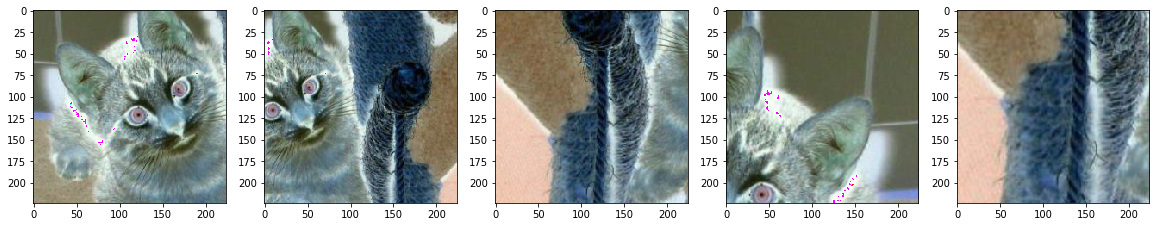

In [2]:
from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline

view_iter = mx.io.ImageRecordIter(path_imgrec='catsdogs_train.rec',
                                   min_img_size=256,
                                   data_shape=(3, 224, 224),
                                   rand_crop=True,
                                   shuffle=False,
                                   batch_size=1,
                                   max_random_scale=1.5,
                                   min_random_scale=0.75,
                                   rand_mirror=True)

images = []
for j in range(5):
    for i, batch in enumerate(view_iter):
        images.append(batch.data[0].asnumpy().squeeze())
        view_iter.reset()
        break
        
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(20, 20))
for i, image in enumerate(images):
    ax[i].imshow(image.swapaxes(0,1).swapaxes(1,2))

#### 학습/테스트 이터레이터 생성 

In [3]:
#생성한 rec 파일로 이터레이터를 생성한다. 
#Tensorflow와 케라스에서와는 다르게 채널이 먼저 나온다.
#이미지 학습을 하는데 ImageRecordIter는 거의 필수라고 생각하는데, 이는 다양한 data augmentation의 옵션을 제공하기 때문이다.
batch_size = 50  # GPU메모리 크기에 따라 정해준다. 
valid_batch_size = 60 #validation은 적어도 큰 문제가 없다. 
train_iter = mx.io.ImageRecordIter(path_imgrec='catsdogs_train.rec',
                                   min_img_size=256,
                                   data_shape=(3, 224, 224),
                                   rand_crop=True,
                                   shuffle=True,
                                   batch_size=batch_size,
                                   max_random_scale=1.5,
                                   min_random_scale=0.75,
                                   rand_mirror=True)
val_iter = mx.io.ImageRecordIter(path_imgrec="catsdogs_test.rec",
                                 min_img_size=256,
                                 data_shape=(3, 224, 224),
                                 batch_size=valid_batch_size)

#### 모형 생성 

In [4]:
#학습은 GPU에서 
ctx = mx.gpu(0)

- Hybrid블록으로 구현 
- vgg16의 `output` 영역을 제외한 부분 기반 transfer 러닝 수행

In [4]:
vgg16_base = models.vgg16(pretrained=True, root=".models", ctx=ctx)

In [5]:
vgg16_base

VGG(
  (features): HybridSequential(
    (0): Conv2D(3 -> 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Activation(relu)
    (2): Conv2D(64 -> 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): Activation(relu)
    (4): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False)
    (5): Conv2D(64 -> 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): Activation(relu)
    (7): Conv2D(128 -> 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): Activation(relu)
    (9): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False)
    (10): Conv2D(128 -> 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): Activation(relu)
    (12): Conv2D(256 -> 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): Activation(relu)
    (14): Conv2D(256 -> 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): Activation(relu)
    (16): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil

In [5]:
class cats_and_dogs(gluon.HybridBlock):
    def __init__(self, num_class, num_hidden , **kwargs):
        super(cats_and_dogs, self).__init__(**kwargs)
        
        with self.name_scope():
            #model zoo에서 vgg16 모형을 가져온다. 
            #이렇게 vgg를 클래스 내부에서 로딩하면 인스턴스마다 context, prefix 가 통일되게 생성되어 모형 저장/로딩시 용이한 측면이 있다.  
            self.vgg_net =  models.vgg16(pretrained=True, root=".models").features
            self.classifier = nn.HybridSequential()
            with self.classifier.name_scope():
                self.classifier.add(nn.Dense(num_hidden, activation="relu"))
                self.classifier.add(nn.Dense(int(num_hidden/2), activation="relu"))
                self.classifier.add(nn.Dense(units=num_class))            
    
    def hybrid_forward(self, F, inputs):
        o_vgg = self.vgg_net(inputs)
        #print("o_vgg shape : {}".format(o_vgg.shape))
        pred = self.classifier(o_vgg)
        return pred
        
        
        

In [54]:
model = cats_and_dogs(num_class=2, num_hidden=512)

In [55]:
print(model)

cats_and_dogs(
  (vgg_net): HybridSequential(
    (0): Conv2D(3 -> 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Activation(relu)
    (2): Conv2D(64 -> 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): Activation(relu)
    (4): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False)
    (5): Conv2D(64 -> 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): Activation(relu)
    (7): Conv2D(128 -> 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): Activation(relu)
    (9): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False)
    (10): Conv2D(128 -> 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): Activation(relu)
    (12): Conv2D(256 -> 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): Activation(relu)
    (14): Conv2D(256 -> 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): Activation(relu)
    (16): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0,

#### Parameter initialization

- vgg_net 블럭의 학습을 fix한다. 
- classifier 블럭의 학습을 위해 가중치 초기화 
- Context를 모두 같은 곳으로 명시 

In [56]:
model.vgg_net.collect_params().setattr('grad_req', 'null')
model.classifier.collect_params().initialize(mx.init.Xavier(), ctx=ctx)
model.collect_params().reset_ctx(ctx)

#### Print Shape 

In [46]:
test_input = mx.nd.random_normal(0,1,(10, 3, 224, 224), ctx=ctx)

In [47]:
model(test_input)

o_vgg shape : (10, 4096)



[[-0.38503259 -0.60042572]
 [-0.40843636 -0.65908098]
 [-0.47609156 -0.74162102]
 [-0.41697636 -0.69639099]
 [-0.36592302 -0.70131874]
 [-0.46205795 -0.61359417]
 [-0.37501001 -0.50521481]
 [-0.3293184  -0.66584158]
 [-0.42603534 -0.72638071]
 [-0.27153084 -0.63436508]]
<NDArray 10x2 @gpu(0)>

In [57]:
sym_data = mx.sym.Variable('data')
net = model(sym_data)

In [58]:
viz = mx.viz.plot_network(net,title='cats_and_dogs_network', save_format='png', shape={'data':(1,3,224,224)})
viz.render('cats_and_dogs_network')

'cats_and_dogs_network.png'

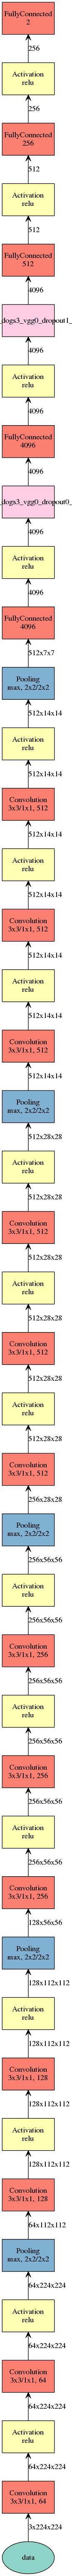

In [59]:
from IPython.display import Image
Image("cats_and_dogs_network.png")

In [60]:
print(net.tojson())

{
  "nodes": [
    {
      "op": "null", 
      "name": "data", 
      "inputs": []
    }, 
    {
      "op": "null", 
      "name": "cats_and_dogs3_vgg0_conv0_weight", 
      "attrs": {
        "__dtype__": "0", 
        "__init__": "[\"xavier\", {\"rnd_type\": \"gaussian\", \"factor_type\": \"out\", \"magnitude\": 2}]", 
        "__lr_mult__": "1.0", 
        "__shape__": "(64, 3, 3, 3)", 
        "__wd_mult__": "1.0"
      }, 
      "inputs": []
    }, 
    {
      "op": "null", 
      "name": "cats_and_dogs3_vgg0_conv0_bias", 
      "attrs": {
        "__dtype__": "0", 
        "__init__": "zeros", 
        "__lr_mult__": "1.0", 
        "__shape__": "(64,)", 
        "__wd_mult__": "1.0"
      }, 
      "inputs": []
    }, 
    {
      "op": "Convolution", 
      "name": "cats_and_dogs3_vgg0_conv0_fwd", 
      "attrs": {
        "dilate": "(1, 1)", 
        "kernel": "(3, 3)", 
        "layout": "NCHW", 
        "no_bias": "False", 
        "num_filter": "64", 
        "num_group"

In [61]:
model.hybridize()

#### Softmax cross-entropy Loss

In [21]:
loss = gluon.loss.SoftmaxCrossEntropyLoss(sparse_label=False)

#### Optimizer

In [22]:
trainer = gluon.Trainer(model.collect_params(), 'adam', {'learning_rate': .001})

#### Write evaluation loop to calculate accuracy

In [23]:
def evaluate(net, data_iter, ctx):
    data_iter.reset()
    acc = mx.metric.Accuracy()
    for batch in data_iter:
        mx.nd.waitall()
        #reference 
        #https://mxnet.incubator.apache.org/api/python/gluon/model_zoo.html
        data = color_normalize(batch.data[0]/255,
                               mean=mx.nd.array([0.485, 0.456, 0.406]).reshape((1,3,1,1)),
                               std=mx.nd.array([0.229, 0.224, 0.225]).reshape((1,3,1,1)))
        
        data = data.as_in_context(ctx)
        label = batch.label[0].as_in_context(ctx)
        with autograd.predict_mode():
            output = net(data)
        predictions = mx.nd.argmax(output, axis=1)
        acc.update(preds=predictions, labels=label)
        mx.ndarray.waitall()
    return acc.get()[1]


In [24]:
import mxnet.autograd as autograd
from mxnet import gluon
import logging
import os
import time
import numpy as np
logging.basicConfig(level=logging.INFO)

def train(net,trainer,loss, train_iter, val_iter, epochs, ctx):
    val_accs = []
    val_acc = evaluate(net, val_iter, ctx)
    val_accs.append(val_acc)
    logging.info('[Initial] validation accuracy : {}'.format(val_accs))
    tr_loss = []
    for epoch in range(epochs):
        tic = time.time()
        train_iter.reset()
        btic = time.time()
        loss_seq = []
        for i, batch in enumerate(train_iter):
            #속도를 좀 감소시키더라도 GPU 메모리에 대한 관리를 더 한다.  
            mx.nd.waitall()
            data = color_normalize(batch.data[0]/255,
                                   mean=mx.nd.array([0.485, 0.456, 0.406]).reshape((1,3,1,1)),
                                   std=mx.nd.array([0.229, 0.224, 0.225]).reshape((1,3,1,1)))
            data = data.as_in_context(ctx)
            label = mx.nd.one_hot(batch.label[0].as_in_context(ctx),2)
            with autograd.record():
                z = net(data)
                L = loss(z, label)
                L.backward()
            trainer.step(data.shape[0])
            btic = time.time()
            curr_loss = mx.nd.mean(L).asscalar()
            loss_seq.append(curr_loss)
            mx.ndarray.waitall()
        logging.info('[Epoch {}] training loss : {}'.format(epoch, np.mean(loss_seq)))
        logging.info('[Epoch %d] time cost: %f'%(epoch, time.time()-tic))
        val_acc = evaluate(net, val_iter, ctx)
        logging.info('[Epoch %d] validation accuracy : %s'%(epoch, val_acc))
        val_accs.append(val_acc)
        tr_loss.append(np.mean(loss_seq))
    return(val_accs, tr_loss)

In [25]:
accs, losses = train(model,trainer, loss, train_iter, val_iter,3, ctx)

INFO:root:[Initial] validation accuracy : [0.34967532467532469]
INFO:root:[Epoch 0] training loss : 0.15711505711078644
INFO:root:[Epoch 0] time cost: 40.655915
INFO:root:[Epoch 0] validation accuracy : 0.980357142857
INFO:root:[Epoch 1] training loss : 0.12282949686050415
INFO:root:[Epoch 1] time cost: 41.021124
INFO:root:[Epoch 1] validation accuracy : 0.980204962244
INFO:root:[Epoch 2] training loss : 0.11350852996110916
INFO:root:[Epoch 2] time cost: 41.305763
INFO:root:[Epoch 2] validation accuracy : 0.979761904762


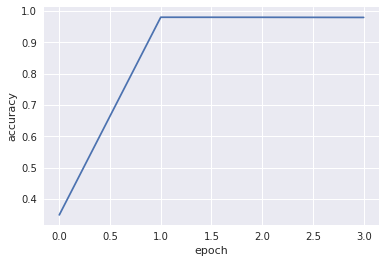

In [26]:
sns.set()
_, ax = plt.subplots(1)
ax.set_xlabel("epoch")
ax.set_ylabel("accuracy")
ax.plot(accs)


첫 에폭에서 98%의 정확도를 보여준다. 

#### 분류 예제 

In [27]:
from skimage.color import rgba2rgb
from skimage import io
from matplotlib import pyplot as plt
%matplotlib inline

#cpu에서 동작 시킨다.  
model.collect_params().reset_ctx(mx.cpu(0))

#reference : http://gluon.mxnet.io/chapter08_computer-vision/fine-tuning.html
def classify_dogcat(net, url): 
    I = io.imread(url)
    if I.shape[2] == 4:
        I = rgba2rgb(I)
    image = mx.nd.array(I).astype(np.uint8)
    plt.subplot(1, 2, 1)
    plt.imshow(image.asnumpy())
    image = mx.image.resize_short(image, 256)
    image, _ = mx.image.center_crop(image, (224, 224))
    plt.subplot(1, 2, 2)
    plt.imshow(image.asnumpy())
    image = mx.image.color_normalize(image.astype(np.float32)/255,
                                     mean=mx.nd.array([0.485, 0.456, 0.406]),
                                     std=mx.nd.array([0.229, 0.224, 0.225]))
    image = mx.nd.transpose(image.astype('float32'), (2,1,0))
    image = mx.nd.expand_dims(image, axis=0)
    out = mx.nd.SoftmaxActivation(net(image))
    print('Probabilities are: '+str(out[0].asnumpy()))
    result = np.argmax(out.asnumpy())
    outstring = ['cat!', 'dog!']
    print(outstring[result])

Probabilities are: [  9.99245286e-01   7.54768844e-04]
cat!


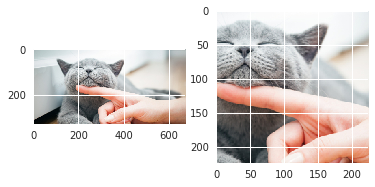

In [28]:
classify_dogcat(net=model, url="cats.jpg")

아주 정확하게 예측함 

Probabilities are: [  9.64187435e-04   9.99035835e-01]
dog!


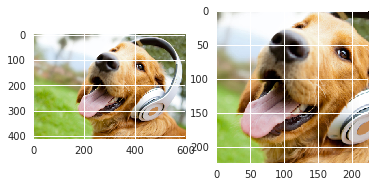

In [29]:
classify_dogcat(net=model, url="Cute-dog-listening-to-music-1_1.jpg")

#### 모형 저장/로딩 

In [31]:
model.save_params("cats_and_dogs_model_tran.mdl")

In [33]:
new_model = cats_and_dogs(num_class=2, num_hidden=512)

In [35]:
new_model.load_params('cats_and_dogs_model_tran.mdl', ctx=mx.cpu(0))

Probabilities are: [  9.64187435e-04   9.99035835e-01]
dog!


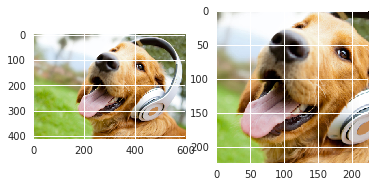

In [36]:
classify_dogcat(net=new_model, url="Cute-dog-listening-to-music-1_1.jpg")